**Table of contents**<a id='toc0_'></a>    
- [A*によるグローバルパスプランニング](#toc1_)    
  - [参考サイト](#toc1_1_)    
- [pybulletの起動](#toc2_)    
- [初期設定](#toc3_)    
- [環境地図の作成](#toc4_)    
  - [障害物を生成、環境地図を作成する関数の定義](#toc4_1_)    
  - [障害物の生成、環境地図の作成](#toc4_2_)    
- [A*クラスの定義](#toc5_)    
- [A*の実行](#toc6_)    
- [おまけ：アニメーションの表示](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[A*によるグローバルパスプランニング](#toc0_)

本notebookではA*について説明します。

（pybulletで使用可能な関数がまとめられたマニュアルについては[こちら](https://github.com/bulletphysics/bullet3/blob/master/docs/pybullet_quickstartguide.pdf)を参照してください。）


A*は、「グローバルパスプランニング」の手法の一つで、スタート地点からゴール地点までの最短経路を探索するアルゴリズムです。

基本的には、グローバルパスプランニングのみでプランニングすることは少なく、dwaのような「ローカルパスプランニング」と組み合わせて使用されることが多いです。

<br>

具体的には、

1. グローバルパスプランニングで初期地点から目標地点までの大域的な経路を計画します。
   
<img src="../images/MobileRobot/mobile_robot_local_path_planning_dwa/global_path_planning.png" width="50%">


<br>
<br>

2. グローバルパスプランニングにより計画された大域的な経路をいくつかの中間地点に分割し、ローカルパスプランニングにより「中間地点1」→「中間地点2」→「中間地点3」→...→「目標地点」のように順番に走行します。

<img src="../images/MobileRobot/mobile_robot_local_path_planning_dwa/local_path_planning.png" width="50%">

なお、ローカルパスプランニングの場合は、リアルタイムに周りの環境を考慮しながら目標地点に走行します。  
そのため、障害物が少し移動する程度なら、グローバルパスプランニングを再計画することなく、障害物を避けながら目標地点に到達することができます。

## <a id='toc1_1_'></a>[参考サイト](#toc0_)
- [よくわかるA*(A-star)アルゴリズム (Unity2Dのサンプルコードつき)](https://qiita.com/2dgames_jp/items/f29e915357c1decbc4b7)
- [A* -Wikipedia](https://ja.wikipedia.org/wiki/A*)
- [簡単なA* （A star）経路探索アルゴリズム（Pythonコードつき）](https://stone-program.com/python/algorithm/a-star-introduction/#google_vignette)
- [PythonRobotics: a_star.py](https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/AStar/a_star.py)

# <a id='toc2_'></a>[pybulletの起動](#toc0_)

In [1]:
import pybullet
import pybullet_data
physics_client = pybullet.connect(pybullet.GUI) 

pybullet build time: Nov 28 2023 23:45:17


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Mesa
GL_RENDERER=llvmpipe (LLVM 15.0.7, 256 bits)
GL_VERSION=4.5 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
GL_SHADING_LANGUAGE_VERSION=4.50
pthread_getconcurrency()=0
Version = 4.5 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
Vendor = Mesa
Renderer = llvmpipe (LLVM 15.0.7, 256 bits)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


# <a id='toc3_'></a>[初期設定](#toc0_)

環境や、ロボットの生成などの処理設定を行います。

In [2]:
import math

pybullet.resetSimulation() # シミュレーション空間をリセット
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # pybulletに必要なデータへのパスを追加
pybullet.setGravity(0.0, 0.0, -9.8) # 地球上における重力に設定
time_step = 0.1
pybullet.setTimeStep(time_step) # 1stepあたりに経過する時間の設定

# シミュレーション空間をリセット
pybullet.resetSimulation() 

#床の読み込み
plane_id = pybullet.loadURDF("plane.urdf")

# ロボットの読み込み
car_start_pos = [0.5, 0.5, 0.1]  # 初期位置(x,y,z)を設定
car_start_yaw = math.radians(0)
car_start_orientation = pybullet.getQuaternionFromEuler([0, 0, car_start_yaw]) # 初期姿勢(roll, pitch, yaw)をクォータニオンに変換
car_id = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf",car_start_pos, car_start_orientation)

# GUIモードの際のカメラの位置などを設定
camera_distance = 6.0
camera_yaw = 180.0 # deg
camera_pitch = -90.1 # deg
camera_target_position = [3.0, 3.0, 0.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

ven = Mesa
ven = Mesa


# <a id='toc4_'></a>[環境地図の作成](#toc0_)

2次元平面での移動ロボットの経路計画では、環境地図を作成し、その地図上でロボットの経路を計画することが一般的です。

ここでは、pybullet上に障害物を生成し、その障害物情報を反映した環境地図を作成します。

今回は、`wall_size`で指定したサイズの壁を生成し、その範囲を環境地図とします。

環境地図は、各セルのサイズが`m_per_pixel`のグリッドマップとして作成します。
- `m_per_pixel`が小さいほど、細かいグリッドマップが作成され、精度が向上しますが、経路計画の際の計算量が増加します。
- 逆に、`m_per_pixel`が大きいほど、粗いグリッドマップが作成され、精度が低下しますが、計算量が減少するため、高速に経路が求まります。

<img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/obstacle_real_to_map.png" width="80%">

<br>

また、「ロボットの半径`robot_radius`」分だけ、障害物を膨張することで、経路計画の際に移動ロボットを点として扱うことができます。

※ 移動ロボットを点として扱うことで、経路計画の衝突判定を効率的に行うことができます。

<img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/obstacle_expansion.png" width="50%">

## <a id='toc4_1_'></a>[障害物を生成、環境地図を作成する関数の定義](#toc0_)

In [3]:
# Jupyter Notebook用の設定
%matplotlib inline
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

def create_wall(wall_size, wall_thickness, wall_height):
    """
    pybullet上に四方を囲む壁を作成

    Args:
    wall_size (float): 壁の一辺の長さ
    wall_thickness (float): 壁の厚さ
    wall_height (float): 壁の高さ
    """
    wall_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[wall_size/2, wall_thickness/2, wall_height/2])
    wall_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[wall_size/2, wall_thickness/2, wall_height/2], rgbaColor=[0.5,0.5,0.5,1])
    wall_ids = []
    wall_ids.append(pybullet.createMultiBody(0, wall_collision_id, wall_visual_id, [wall_size/2, -wall_thickness/2, wall_height/2]))
    wall_ids.append(pybullet.createMultiBody(0, wall_collision_id, wall_visual_id, [wall_size/2, wall_size+wall_thickness/2, wall_height/2]))
    wall_ids.append(pybullet.createMultiBody(0, wall_collision_id, wall_visual_id, [-wall_thickness/2, wall_size/2, wall_height/2], pybullet.getQuaternionFromEuler([0, 0, math.pi/2])))
    wall_ids.append(pybullet.createMultiBody(0, wall_collision_id, wall_visual_id, [wall_size+wall_thickness/2, wall_size/2, wall_height/2], pybullet.getQuaternionFromEuler([0, 0, math.pi/2])))
    return wall_ids

def create_obstacle(box_size_min, box_size_max, obstacle_num, wall_size):
    """
    pybullet上にランダムな障害物（立方体）を作成

    Args:
    box_size_min (float): 障害物の最小サイズ
    box_size_max (float): 障害物の最大サイズ
    obstacle_num (int): 障害物の数
    wall_size (float): 壁の一辺の長さ
    """
    #　左下を原点とした座標系の中で、壁の範囲内にランダムに障害物を配置
    obstacles = []
    for _ in range(obstacle_num):
        box_size = random.uniform(box_size_min, box_size_max)
        x = random.uniform(0+box_size, wall_size-box_size)
        y = random.uniform(0+box_size, wall_size-box_size)
        yaw = random.uniform(0, math.pi)
        obstacles.append([box_size, x, y, yaw])

    # pybullet上に障害物を配置 
    obstacles_id = []
    for obstacle in obstacles:
        box_size = obstacle[0]
        x = obstacle[1]
        y = obstacle[2]
        yaw = obstacle[3]
        obstacle_id = pybullet.loadURDF("../urdf/simple_box.urdf", [x, y, box_size/2], pybullet.getQuaternionFromEuler([0,0,yaw]), globalScaling=box_size*2, useFixedBase=True)
        obstacles_id.append(obstacle_id)
        pybullet.changeVisualShape(obstacle_id, -1, rgbaColor=[1, 0, 0, 1])
    return obstacles, obstacles_id

def draw_wall(environment_image):
    """
    四方を囲む壁を描画

    Args:
    environment_image (np.array): 環境の画像
    """
    # 壁の領域を0で塗りつぶす
    environment_image[0, :] = 0
    environment_image[-1, :] = 0
    environment_image[:, 0] = 0
    environment_image[:, -1] = 0


def draw_obstacle(obstacles, environment_image, m_per_pixel, robot_radius):
    """
    障害物を描画

    Args:
    obstacle (list): 障害物の情報 [box_size, x, y, yaw]
    environment_image (np.array): 環境の画像
    m_per_pixel (float): 1ピクセルあたりのメートル数
    robot_radius (float): ロボットの半径
    """
    # 障害物の領域を0で塗りつぶす
    for obstacle in obstacles:

        # 移動ロボットの大きさ分だけ障害物を大きくすることで
        # 移動ロボットを点として扱うことが可能となり、経路計画の際の衝突判定を行いやすくなる
        box_size = obstacle[0] + robot_radius  

        # 地図座標系における障害物の大きさ、位置、角度を計算
        box_size_map = int(box_size * (1/m_per_pixel))
        x = int(obstacle[1]*(1/m_per_pixel))
        y = int(obstacle[2]*(1/m_per_pixel))
        yaw = obstacle[3]

        # 障害物の4つの頂点を計算
        corners = np.array([[-box_size_map, box_size_map, box_size_map, -box_size_map, -box_size_map],
                            [-box_size_map, -box_size_map, box_size_map, box_size_map, -box_size_map]])
        R = np.array([[math.cos(yaw), -math.sin(yaw)], [math.sin(yaw), math.cos(yaw)]])
        rotated_corners = R @ corners
        rotated_corners[0] += x
        rotated_corners[1] += y
        
        # 障害物の頂点を結んだ線を描画
        for i in range(4):
            cv2.line(environment_image, (int(rotated_corners[0][i]), int(rotated_corners[1][i])), (int(rotated_corners[0][i+1]), int(rotated_corners[1][i+1])), 0, 2)


## <a id='toc4_2_'></a>[障害物の生成、環境地図の作成](#toc0_)

以下変数を変更することで、異なる環境地図を作成することができます。
- `wall_size` : 四方を囲む壁のサイズ（この壁の中で経路計画を行う）
- `obstacle_num` : 生成する障害物の数
- `box_size_min` : 障害物の最小サイズ
- `box_size_max` : 障害物の最大サイズ（最小サイズと最大サイズの間でランダムなサイズの立方体を生成）
- `m_per_pixel` : グリッドマップの1セルのサイズ（単位：m）
- `robot_radius` : ロボットの半径（単位：m）
  - ロボットの半径分だけ、障害物が膨張されます。


※ デフォルトでは、`random.seed(10)`で乱数のシードを固定しているため、同じ環境地図が生成されます。

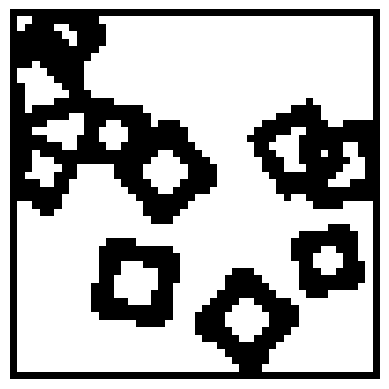

In [4]:
# ランダムシードの設定
random.seed(10)

# 既に存在する障害物を削除
if vars().get('wall_ids') is not None:
    for wall_id in wall_ids:
        pybullet.removeBody(wall_id)
if vars().get('obstacles_id') is not None:
    for obstacle_id in obstacles_id:
        pybullet.removeBody(obstacle_id)

# 四方を囲む壁の作成
wall_size = 5
wall_thickness = 0.1
wall_height = 0.5
wall_ids = create_wall(wall_size, wall_thickness, wall_height)

# 障害物のボックスのサイズ、位置のリストを作成 ([box_size,  box_size], [x, y, yaw])
obstacle_num = 10
box_size_min = 0.1
box_size_max = 0.3
obstacles, obstacles_id = create_obstacle(box_size_min, box_size_max, obstacle_num, wall_size)

# pybulletに生成したオブジェクトに合わせて、環境地図の画像を作成
m_per_pixel = 0.1  # 1ピクセルあたりのメートル
robot_radius = 0.2  # ロボットの半径
image_size = int(wall_size * (1/m_per_pixel))
environment_image = np.full((image_size, image_size), 255, dtype=np.uint8)
draw_wall(environment_image)
draw_obstacle(obstacles, environment_image, m_per_pixel, robot_radius)

# 作成した環境地図を表示
# 左上が原点になるように画像を反転
environment_image = cv2.flip(environment_image, 0)
# メモリを非表示
plt.axis('off')
plt.imshow(environment_image, cmap='gray')

# <a id='toc5_'></a>[A*クラスの定義](#toc0_)

A*は、スタート地点からゴール地点までの最短経路を探索するアルゴリズムです。

大まかな手順は以下の通りです。

1. 初期化
   - `__init__`メソッドで初期化を行います。

<br>

2. 「環境地図`enviroment_map`」をもとに「ノード地図`nodes_map`」を作成します。  
   <img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/nodes_map.png" width="80%">
   - 各ノードは、以下の情報を持ちます。
     - `x_map`: ノードのx座標
     - `y_map`: ノードのy座標
     - `cost_start_to_node` : 「スタート地点からノード」までのコスト。初期値は無限大として設定し、探索中に最短距離が更新されるたびに更新されます。
     - `cost_node_to_goal` : 「ノードからゴール地点」までのコスト。探索中に、ノード～ゴール地点までの実際のコストは分からないため、「ノード～ゴール地点までのユークリッド距離」をコストとして設定します。
       - あくまで推定（ヒューリスティックな）コストであるため、実際のコストとは異なります。
       - 例えば、直線上に障害物がある場合、実際のコストは障害物を避けるために迂回するため、`cost_node_to_goal`よりも大きくなります。
     - 2つのコストをまとめると、以下図のようになります。
         <img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/cost_example.png" width="80%"> 
     - `is_obstacle`: ノードが障害物上にあるかどうか
     - `parent`: 親ノード
     - `is_explored`: ノードが探索済みかどうか


3. スタート地点のノードの`cost_start_to_node`を0に設定します

4. `is_explored`がFalse（探索中）のノードの中から、`cost_start_to_node`」が最小のノードを選択します。

5. 選択したノード（以降、現在ノードと呼ぶ）の`is_explored`をTrue（探索済み）に設定します。


6. 現在ノードの「周囲8pixelのノード（周辺ノード）」の、「スタート～周辺ノードまでの新コスト`cost_start_to_node_new`」を計算します。  
   <img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/next_node.png" width="30%">
   - 具体的には「`cost_start_to_node_new` = `nodes_map[x_map_current][y_map_current].cost_start_to_node` + 現在ノード～周辺ノードへの移動距離」を計算します。  
   <img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/next_node_cost.png" width="100%">

<br>

7. 「`cost_start_to_node_new`」 < 「周辺ノードの`cost_start_to_node`」の場合
   - 周辺ノードの`cost_start_to_node`を`cost_start_to_node_new`に更新し、
   - 周辺ノードの`parent`を現在ノードに設定します。


8. ゴール地点に到達するまで、3.～6.を繰り返します。

なお、以下コードでは「実座標系の座標」と「地図座標系の座標」を区別するため、それぞれ
- `x_real`, `y_real` : 実座標系の座標
- `x_map`, `y_map` : 地図座標系の座標

のように変数名を設定しています。

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

class MapNode:
    def __init__(self, x_map, y_map):
        """
        マップ上のノード
        Attributes
        ----------
        x_map : int
            ノードのx座標（地図座標系）
        y_map : int
            ノードのy座標（地図座標系）
        cost_start_to_node : float
            スタート～ノードまでのコスト
                スタート～ノードまでの「実際に探索して求めた最短距離」をコストとして設定（初期値は無限大）
        cost_node_to_goal : float
            ノード～ゴールまでのコスト
                ノード～ゴールまでの「ユークリッド距離」をコストとして設定
                cost_node_to_goalヒューリスティックなコストであるため、実際のコストとは異なる
                例えば、結んだ直線の間に障害物がある場合、実際のコストはユークリッド距離よりも大きくなる
        parent : MapNode
            親ノード
        is_obstacle : bool
            障害物が存在するかどうか
        is_explored : bool
            探索済みかどうか
        """
        self.x_map = x_map
        self.y_map = y_map
        self.cost_start_to_node = float("inf")
        self.cost_node_to_goal = float("inf")
        self.is_obstacle = False
        self.parent = None
        self.is_explored = False

class AStar:
    def __init__(self, x_real_start, y_real_start, x_real_goal, y_real_goal, environment_map, m_per_pixel, heuristic_weight, save_animation=False):
        """
        Attributes
        ----------
        x_real_start : float
            スタート地点のx座標（実座標系）
        y_real_start : float
            スタート地点のy座標（実座標系）
        x_real_goal : float
            ゴール地点のx座標（実座標系）
        y_real_goal : float
            ゴール地点のy座標（実座標系）
        environment_map : numpy.ndarray
            環境地図（障害物が0、通行可能な場所が255となっている2次元配列）
        m_per_pixel : float
            1ピクセルあたりの実空間の大きさ（m/pixel）
        heuristic_weight : float
            ヒューリスティックの重み
        is_save_map_images : bool
            地図画像を保存するかどうか（アニメーション用）
        nodes_map : list
            ノードの2次元配列
        explore_map : numpy.ndarray
            探索済みのノードを描画するための画像（アニメーション用）
        fig : matplotlib.figure.Figure
            描画用のFigure（アニメーション用）
        ax : matplotlib.axes.Axes
            描画用のAxes（アニメーション用）
        image : matplotlib.image.AxesImage
            描画用の画像（アニメーション用）
        """
        self.x_real_start = x_real_start
        self.y_real_start = y_real_start
        self.x_real_goal = x_real_goal
        self.y_real_goal = y_real_goal
        self.environment_map = environment_map
        self.m_per_pixel = m_per_pixel
        self.heuristic_weight = heuristic_weight
        self.is_save_map_images = save_animation
        self.nodes_map = self.create_nodes_map()
        if self.is_save_map_images:
            self.explore_map = self.create_searched_map()
            self.fig, self.ax = plt.subplots(figsize=(self.environment_map.shape[0], self.environment_map.shape[1]), dpi=10)
            self.ax.set_xlim(0, self.environment_map.shape[0])
            self.ax.set_ylim(0, self.environment_map.shape[1])
            self.ax.axis('off')
            self.fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
            self.image = self.ax.imshow(self.explore_map, animated=True)
            self.map_image_array = []

    def create_nodes_map(self):
        """
        ノード地図の2次元配列を作成

        Returns
        -------
        nodes_map : list
            ノード地図の2次元配列
        """
        goal_x_map, goal_y_map = self.real_to_map(self.x_real_goal, self.y_real_goal)
        # nodes_mapの2次元配列を作成
        nodes_map = np.empty((self.environment_map.shape[0], self.environment_map.shape[1]), dtype=object)
        for x_map in range(self.environment_map.shape[0]):
            for y_map in range(self.environment_map.shape[1]):
                # ヒューリスティックコストの設定
                # 今回、ヒューリスティックコストは 「ノード[x_map][y_map]」から「ノード[goal_x_map][goal_y_map]」までのユークリッド距離とする
                # そのため、ヒューリスティックコストは不変であるため、あらかじめ計算しておく
                # ※ ここでは、分かりやすさのためあらかじめ計算しているが、地図が大きくなるとメモリを大量に消費するため、実際のアルゴリズムでは必要な時に逐次的に計算することが一般的
                cost_node_to_goal = self.calc_cost_node_to_goal(x_map, y_map, goal_x_map, goal_y_map, self.heuristic_weight)
                nodes_map[x_map][y_map] = MapNode(x_map, y_map)
                nodes_map[x_map][y_map].cost_node_to_goal = cost_node_to_goal
                
                # ノードの座標を設定
                nodes_map[x_map][y_map].x_map = x_map
                nodes_map[x_map][y_map].y_map = y_map
                
                # 障害物の有無を設定
                if self.environment_map[x_map][y_map] == 0:
                    nodes_map[x_map][y_map].is_obstacle = True
        return nodes_map

    def create_searched_map(self):
        """
        探索済みのノードを描画するための2次元配列を作成（アニメーション用）
        """
        searched_map = np.full((self.environment_map.shape[0], self.environment_map.shape[1], 3), 255, dtype=np.uint8)
        return searched_map
        
    def real_to_map(self, x_real, y_real):
        """
        実座標を画像上の座標に変換

        Parameters
        ----------
        x_real : float
            実座標のx座標
        y_real : float
            実座標のy座標

        Returns
        -------
        x_map : int
            画像上のx座標
        y_map : int
            画像上のy座標
        """
        x_map = int(x_real / self.m_per_pixel)
        y_map = int(y_real / self.m_per_pixel) # numpy配列のy座標は左上が原点なので、y座標を反転
        return x_map, y_map
    
    def map_to_real(self, x_map, y_map):
        """
        画像上の座標を実座標に変換

        Parameters
        ----------
        x_map : int
            画像上のx座標
        y_map : int
            画像上のy座標

        Returns
        -------
        x_real : float
            実座標のx座標
        y_real : float
            実座標のy座標
        """
        x_real = x_map * self.m_per_pixel
        y_real = y_map * self.m_per_pixel
        return x_real, y_real
    
    def find_min_cost_node_xy(self, nodes_map):
        """
        探索中のノードの中で、最もコストが低いノードの位置を取得

        Parameters
        ----------
        nodes_map
            ノードの2次元配列

        Returns
        -------
        x_map_min : int
            最もコストが低いノードのx座標
        y_map_min : int
            最もコストが低いノードのy座標
        """
        cost_total_min = float("inf")
        x_map_min = None
        y_map_min = None
        for x_map in range(nodes_map.shape[0]):
            for y_map in range(nodes_map.shape[1]):
                cost_total = nodes_map[x_map][y_map].cost_start_to_node + nodes_map[x_map][y_map].cost_node_to_goal
                if nodes_map[x_map][y_map].is_explored == False and cost_total < cost_total_min:
                    cost_total_min = cost_total
                    x_map_min = x_map
                    y_map_min = y_map
        return x_map_min, y_map_min

    def add_map_image(self, environment_map, explore_map, map_image_array):
        """
        地図画像を作成し、map_image_arrayに追加

        Parameters
        ----------
        environment_map : numpy.ndarray
            環境地図
        explore_map : numpy.ndarray
            探索済みのノードを描画するための画像
        map_image_array : list
            地図画像のリスト
        """
        # 環境地図を白黒 -> RGBに変換
        environment_map_rgb = np.stack([environment_map] * 3, axis=2)

        # 障害物 + 探索済みのノードの描画
        combined_map = environment_map_rgb & explore_map

        # 画像用のデータは[y][x][channel]の順番である必要があるため、xとyを入れ替えてから追加
        combined_map = combined_map.transpose(1, 0, 2)
        map_image_array.append(combined_map)
        
    def calc_cost_node_to_goal(self, x_map_current, y_map_current, x_map_goal, y_map_goal, heuristic_weight):
        """
        ヒューリスティックコストの計算

        Parameters
        ----------
        x_map_current : int
            現在のx座標
        y_map_current : int
            現在のy座標
        x_map_goal : int
            ゴールのx座標
        y_map_goal : int
            ゴールのy座標
        heuristic_weight : float
            ヒューリスティックコストの重み（どの程度ヒューリスティックを信用するか）

        Returns
        -------
        cost_heuristic : float
            ヒューリスティックコスト
        """
        cost_heuristic = heuristic_weight * math.sqrt((x_map_current - x_map_goal) ** 2 + (y_map_current - y_map_goal) ** 2)
        return cost_heuristic
    
    def planning(self):
        """
        経路計画

        Returns
        -------
        path_real : list
            経路の座標（実座標）
        """
        # 経路計画は地図座標系で行う
        x_map_start, y_map_start = self.real_to_map(self.x_real_start, self.y_real_start)
        x_map_goal, y_map_goal = self.real_to_map(self.x_real_goal, self.y_real_goal)

        # スタート地点または、ゴール地点が障害物上にある場合は経路が存在しないため終了
        if self.nodes_map[x_map_start][y_map_start].is_obstacle or self.nodes_map[x_map_goal][y_map_goal].is_obstacle:
            print("Start or goal is in the obstacle")
            return None
        # スタート地点または、ゴール位置が地図外の場合は経路が存在しないため終了
        if x_map_start < 0 or len(self.nodes_map) <= x_map_start or \
              y_map_start < 0 or len(self.nodes_map[0]) <= y_map_start or \
                x_map_goal < 0 or len(self.nodes_map) <= x_map_goal or \
                    y_map_goal < 0 or len(self.nodes_map[0]) <= y_map_goal:
            print("Start or goal is out of the map")
        
        # スタート地点の「スタート～ノードのコスト」を0とする
        self.nodes_map[x_map_start][y_map_start].cost_start_to_node = 0

        # イテレーション回数の設定
        iter_max = self.environment_map.shape[0] * self.environment_map.shape[1] # 地図のマス数 = 最大イテレーション回数
        iter_current = 0

        # ゴールが見つかるまで繰り返す
        while True:
            # イテレーション回数が最大イテレーション回数を超えた場合はゴールが見つからなかったとして終了
            iter_current += 1
            if iter_current > iter_max:
                print("Goal not found")
                break
            
            # 探索中のノードの中で最もコストの低いノードの座標を取得
            x_map_current, y_map_current = self.find_min_cost_node_xy(self.nodes_map)
            
            # 最もコストが低いノードの探索済みフラグを立てる（探索済みフラグが立っているノードは、以降はコストの更新が行われない）
            self.nodes_map[x_map_current][y_map_current].is_explored = True

            # 探索済みのノードを青色で塗る（アニメーション用）
            if self.is_save_map_images:
                self.explore_map[x_map_current][y_map_current] = [0, 0, 255]
                self.add_map_image(self.environment_map, self.explore_map, self.map_image_array)

            # ゴールに到達した場合
            if x_map_current == x_map_goal and y_map_current == y_map_goal:
                print("Goal!!")
                break

            # 「最もコストが低いノードの周囲8方向のノード」の「スタート～ノードのコスト」を更新
            # ※ ここでは「コスト=移動距離」と定義。今回は、2次元平面上のため直進方向のコストは1、斜め方向のコストはsqrt(2)となる
            top = [-1, 0, 1] # [x方向の変位, y方向の変位, その方向に進んだ場合のコスト]
            top_right = [-1, 1, 1.414]
            top_left = [-1, -1, 1.414]
            right = [0, 1, 1]
            left = [0, -1, 1]
            bottom = [1, 0, 1]
            bottom_right = [1, 1, 1.414]
            bottom_left = [1, -1, 1.414]
            directions = [top, top_right, top_left, right, left, bottom, bottom_right, bottom_left]
            for i, j, cost_start_to_node in directions:
                # 周辺ノードの座標を計算
                x_map_next = x_map_current + i
                y_map_next = y_map_current + j

                # 周辺ノードがマップ外の場合はコストの更新を行わない
                if x_map_next < 0 or len(self.nodes_map) <= x_map_next or \
                   y_map_next < 0 or len(self.nodes_map[0]) <= y_map_next:
                    continue
                
                # 周辺ノードが障害物上にある場合はコストの更新を行わない
                if self.nodes_map[x_map_next][y_map_next].is_obstacle:
                    continue
                
                # 周辺ノードが既に探索済みの場合はコストの更新を行わない
                if self.nodes_map[x_map_next][y_map_next].is_explored:
                    continue

                # 「スタート～ノードのコスト」の計算
                cost_start_to_node_new = self.nodes_map[x_map_current][y_map_current].cost_start_to_node + cost_start_to_node

                # 計算したコストが既存のコストよりも低い場合は、コストを更新
                if cost_start_to_node_new < self.nodes_map[x_map_next][y_map_next].cost_start_to_node:
                    self.nodes_map[x_map_next][y_map_next].cost_start_to_node = cost_start_to_node_new
                    self.nodes_map[x_map_next][y_map_next].parent = self.nodes_map[x_map_current][y_map_current]

        # A*によって算出した（地図座標系における）経路を取得
        path_map = []
        current_node = self.nodes_map[x_map_goal][y_map_goal]
        while current_node.parent != None:
            path_map.append([current_node.x_map, current_node.y_map])
            current_node = current_node.parent
        path_map.append([current_node.x_map, current_node.y_map])
        path_map = path_map[::-1]

        # 経路の描画
        if self.is_save_map_images:
            for i in range(len(path_map) - 1):
                x_map_current, y_map_current = path_map[i]
                x_map_next, y_map_next = path_map[i + 1]
                self.explore_map[x_map_current][y_map_current] = [255, 0, 0]
                self.explore_map[x_map_next][y_map_next] = [255, 0, 0]
                self.add_map_image(self.environment_map, self.explore_map, self.map_image_array)

        # 経路の座標を実座標に変換
        path_real = []
        for x_map, y_map in path_map:
            x, y = self.map_to_real(x_map, y_map)
            path_real.append([x, y])
        return path_real

# <a id='toc6_'></a>[A*の実行](#toc0_)

以下の変数を変更することで、異なる環境地図での経路計画を行うことができます。
- `start`: スタート地点の座標
- `goal`: ゴール地点の座標
- `heuristic_weight`: ヒューリスティックコスト（`cost_node_to_goal`）の重み

Goal!!


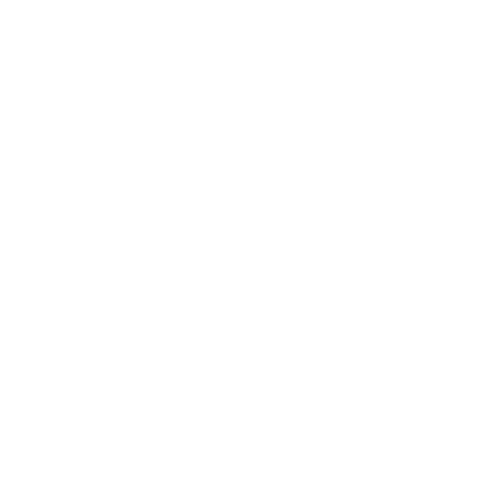

In [11]:
# 環境地図の作成
# 左下が原点となるように画像を反転し、y座標を反転（画像が[-y][x]の座標系であるため、[x][y]の座標系に変換）
environment_map = np.flip(environment_image, 0)
environment_map = environment_map.transpose()

# スタートとゴールの座標
start = [0.5, 0.5]
goal = [4.5, 4.5]

# ============= A*のメイン処理 ===================
# ヒューリスティックの重み
# 重み小：最適な経路が見つかる可能性が高いが、計算時間が長くなりやすい
# 重み大：最適な経路が見つかる可能性が低いが、計算時間が短くなりやすい
# 重み=0：確実に最適な経路を見つけることができるが、計算時間が長くなる可能性が高い（重み=0の場合はダイクストラ法となる。すなわち、A*はダイクストラ法を一般化したものと言える）
heuristic_weight = 1.0 
a_star = AStar(start[0], start[1], goal[0], goal[1], environment_map, m_per_pixel, heuristic_weight, save_animation=True)
path = a_star.planning()
# ================================================

# 経路の描画
if path is not None:
    # Pybullet上に経路を描画
    pybullet.removeAllUserDebugItems() # 既存のデバッグアイテムを削除
    # addUserDebugLineでは3次元座標を指定する必要があるため、z座標を0.01にした3次元の経路を作成
    path_3d = []
    for i in range(len(path)):
        path_3d.append([path[i][0], path[i][1], 0.01])
    for i in range(len(path) - 1):
        pybullet.addUserDebugLine(path_3d[i], path_3d[i + 1], [1, 0, 0], lineWidth=5)

# <a id='toc7_'></a>[おまけ：アニメーションの表示](#toc0_)

A*の経路計画をアニメーションで表示します。

In [7]:
def update(i):
    a_star.image.set_data(a_star.map_image_array[i])
    return a_star.image

# アニメーション化
ani = FuncAnimation(a_star.fig, update, frames=len(a_star.map_image_array), interval=10)
HTML(ani.to_jshtml()) # HTMLに
# ani.save('a_star.mp4', writer="ffmpeg") # mp4で保存．これを実行すると処理時間が増加します